# Analysis of Airbnb listing in Rio de Janiero

In [2]:
import pandas as pd
from config import s3_url

# Load Rio listings from s3 into dataframe
df = pd.read_csv(s3_url + 'listings.csv.gz')

### Most popular individual listings

It appears that popularity is distributed somewhat evenly about
the neighbourhoods until you get past the top five.

What's even more interesting is that there's a sole private room
listing amoung entirely 

In [3]:
# A few features to analyze
columns = ['name','neighbourhood_cleansed','number_of_reviews']

# Sort listings by highest review count
most_pop = df[columns].sort_values('number_of_reviews', ascending=False) \
    .rename(columns={col:' '.join(col.split('_')).title() for col in columns}) \
    .rename(columns={'Neighbourhood Cleansed':'Neighborhood'}) \
    .iloc[:20,:]
    
most_pop.head(10)

,Name,Neighborhood,Number Of Reviews
140,2 bedroom apart with view to the lagoon and ga...,Lagoa,431
301,CASABLANCA 1 STUNNING BEACHFRONT,Vidigal,424
5715,"COPACABANA,PRAIA/METRO,MELHOR CUSTO BENEFÍCIO",Copacabana,419
744,Praia de Copacabana,Copacabana,406
108,❤️ MODERN LOFT IN BEST SPOT OF IPANEMA 1 - 120...,Ipanema,388
393,Apart hotel - COPACABANA beach,Copacabana,375
17,Apart-hotel in Ipanema with service and garage,Ipanema,370
1359,Copacabana Beach - Av Atlântica (Sea View - 11th),Copacabana,362
3,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Copacabana,346
1986,Your home in Copacabana/RJ/Brazil,Copacabana,337


##### The complete names can be seen in the bar chart below 

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px

# Bar chart of most popular listings and their review count
fig = px.bar(most_pop, x='Name', y='Number Of Reviews', color='Neighborhood')
fig.update_layout(xaxis_tickangle=35)
fig.show()

![barplot](../images/bar.png)

Notice that 4/10 of the most popular listings have names with the
same eye-grabbing aestetic choices you'll find on a YouTube trending page

All caps, emojis, etc. It may seem trivial but here is yet more evidence
it can make a difference.


The five most frequented listings are from four different districs

Also notice that some Copacabana listings are in Portugese

### Availability by neighborhood

First lets see what the availability is in the most popular areas

In [5]:
# Take the integer of the average
int_average = lambda x:int(x.mean())

# Columns and their aggregation methods
aggregate = {'id':'count',
             'availability_30':int_average,
             'availability_60':int_average,
             'availability_90':int_average,
             'availability_365':int_average,}

avail_df = df\
    .rename(columns={'neighbourhood_cleansed':'Neighborhood'}) \
    .groupby('Neighborhood') \
    .agg(aggregate).sort_values('id', ascending=False) \
    .drop(columns='id').rename(columns={
        col:"Avg " + ': '.join(col.split('_')) + " Day"
        for col in aggregate if 'avail' in col})
    
# Top 5
avail_df.head()

,Avg availability: 30 Day,Avg availability: 60 Day,Avg availability: 90 Day,Avg availability: 365 Day
Neighborhood,,,,
Copacabana,15,35,56,204
Barra da Tijuca,16,38,62,223
Ipanema,15,34,55,200
Jacarepaguá,18,41,65,228
Botafogo,16,37,60,215


**Compare** to availability in least popular neighbourhoods

In [6]:
avail_df.tail()

,Avg availability: 30 Day,Avg availability: 60 Day,Avg availability: 90 Day,Avg availability: 365 Day
Neighborhood,,,,
Maré,29,59,89,179
Magalhães Bastos,19,49,79,354
Acari,12,42,72,347
Gericinó,30,60,90,365
Água Santa,30,60,90,365


### Visualize the average availability by neighborhood

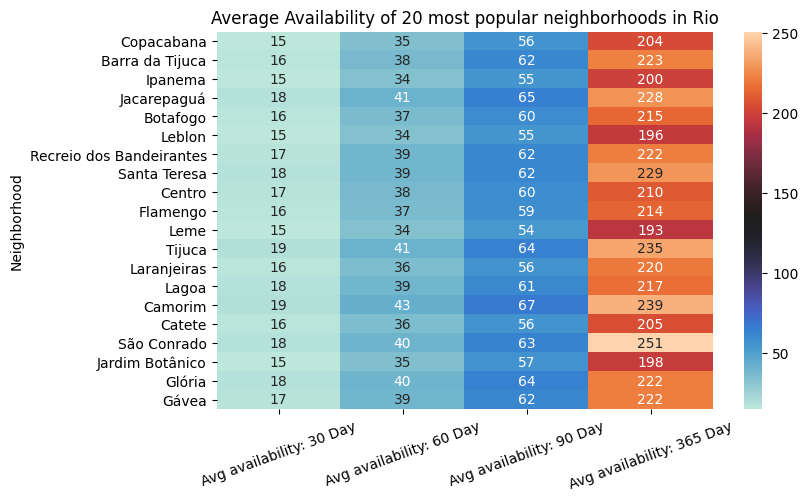

In [7]:
import seaborn as sns

# Average daily availability of 20 most popular neighborhoods
f, ax = plt.subplots(figsize=(8,5),dpi=100)
plot = sns.heatmap(avail_df.iloc[:20,:], cmap='icefire', annot=True, fmt='d')
plot.set_xticklabels(avail_df.columns, rotation=20);
ax.set_title("Average Availability of 20 most popular neighborhoods in Rio");

#### Most popular neighborhoods

In [8]:
# Group by neighbourhood and count the id column
most_popular_neighbourhoods = df\
    .rename(columns={'neighbourhood_cleansed':'Neighborhood'}) \
    .groupby('Neighborhood') \
    .agg({'id':'count'}) \
    .sort_values('id',ascending=False) \
    .rename(columns={'id':"Number of Listings"})

most_popular_neighbourhoods.head(10)

,Number of Listings
Neighborhood,
Copacabana,7378
Barra da Tijuca,2588
Ipanema,2452
Jacarepaguá,1323
Botafogo,1195
Leblon,1157
Recreio dos Bandeirantes,1121
Santa Teresa,892
Centro,742


##### Get further aggregate metrics on the most popular neighbourhoods in rio

For each neighborhood, one might want to know
- How many listings are there?
- What is the average price?


In [9]:
# Clean the price column and get average
clean_price = lambda string:int(string[1:-3].replace(',',''))
price_agg = lambda col:int(col.map(clean_price).mean())


# Aggregate metrics for additional columns
aggregate = {'id':'count','price':price_agg,
             'latitude':'mean','longitude':'mean',}

# Rename columns for readability
new_column_names = {'id':'Number of listings','price':'Average price',
                    'latitude':'Latitude','longitude':'Longitude'}

# Transform data
most_popular_neighbourhoods = df.groupby('neighbourhood_cleansed')\
    .agg(aggregate)\
    .sort_values('id', ascending=False)\
    .rename(columns=new_column_names)

most_popular_neighbourhoods.head(5)

,Number of listings,Average price,Latitude,Longitude
neighbourhood_cleansed,,,,
Copacabana,7378,959,-22.972767,-43.186333
Barra da Tijuca,2588,1077,-23.005272,-43.352296
Ipanema,2452,1096,-22.984353,-43.201281
Jacarepaguá,1323,642,-22.967927,-43.392800
Botafogo,1195,427,-22.950910,-43.184995


#####  Mapbox will break your maps if you request too often, so be careful

In [10]:
import plotly.express as px

# Geographic center for map visualization
center = {
    'lat':most_popular_neighbourhoods['Latitude'].mean(),
    'lon':most_popular_neighbourhoods['Longitude'].mean()
}

# Resize the "Number of listings" column for better visual effect
size = most_popular_neighbourhoods['Number of listings'].map(
    lambda count: count + 10)

# Scatter plot laid over a Mapbox map
fig = px.scatter_mapbox(
    most_popular_neighbourhoods,
    lat='Latitude',
    lon='Longitude',
    zoom=10,
    size=size,
    center=center,
    color='Average price',
    mapbox_style='open-street-map',)


fig.show()

![mapbox](../images/mapbox.png)